# Clasificación de _clickbaits_ en Twitter mediante el uso de _transformers_

## Autor: Fernández Hernández, Alberto

## Fecha: 01/04/2022

In [ ]:
# -- Instalacion de librerias
!pip install shap
!pip install emoji
!pip install transformers
!pip install spacy-langdetect

In [27]:
!python --version

Python 3.7.13


# Librerías importadas + Constantes

In [2]:
# -- Librerias
from   spacy_langdetect  import LanguageDetector        # -- Deteccion lenguajes - SpaCy
from   tqdm              import tqdm                    # -- Barra de progreso
import matplotlib.pyplot as plt                         # -- Libreria grafica (I)
import seaborn           as sns                         # -- Libreria grafica (II)
import pandas            as pd                          # -- Lectura y manipulacion de datos (I)
import numpy             as np                          # -- Lectura y manipulacion de datos (II)
import emoji                                            # -- Conversion de "emojis"
import spacy                                            # -- Libreria para NLP
import re                                               # -- Expresiones regulares

# -- Setup
tqdm.pandas()
plt.style.use('ggplot')

In [3]:
# -- Constantes
TRAIN_DATA_PATH = '/content/drive/MyDrive/Personal/Clickbait/data/webis_train.csv'
TEST_DATA_PATH  = '/content/drive/MyDrive/Personal/Clickbait/data/webis_test.csv'
DATA_PATH       = '/content/drive/MyDrive/Personal/Clickbait/data/'
MODELS_PATH     = '/content/drive/MyDrive/Personal/Clickbait/models/'

# Cargamos el conjunto de entrenamiento + test

In [4]:
train_df = pd.read_csv(TRAIN_DATA_PATH)

Número de filas y columnas en el DataFrame de entrenamiento:

In [5]:
train_df.shape

(19538, 15)

In [6]:
test_df = pd.read_csv(TEST_DATA_PATH)

Número de filas y columnas en el DataFrame de test:

In [7]:
test_df.shape

(18979, 15)

# Mostramos las primeras 5 observaciones:

In [8]:
train_df.head(n=5)

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
0,0,[],UK’s response to modern slavery leaving victim...,858462320779026432,['modern-slavery-rex.jpg'],['Thousands of modern slavery victims have\xa0...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...,"[0.33333333330000003, 0.0, 0.33333333330000003...",0.133333,no-clickbait,0.000000,0.000000
1,1,[],this is good,858421020331560960,"['In this July 1, 2010 file photo, Dr. Charmai...",['President Donald Trump has appointed the\xa0...,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,1.000000,1.000000
2,2,[],"The ""forgotten"" Trump roast: Relive his brutal...",858368123753435136,"[""President Trump will not attend this year's ...",['When the\xa0White House correspondents’ dinn...,The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...,"[0.33333333330000003, 1.0, 0.33333333330000003...",0.466667,no-clickbait,0.333333,0.333333
3,3,[],Meet the happiest #dog in the world!,858323428260139008,"['Maru ', 'Maru', 'Maru', 'Maru', 'Maru']",['Adorable is probably an understatement. This...,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,"Maru, husky, dogs, pandas, furball, instagram","The article is about Maru, a husky dog who has...","[1.0, 0.6666666666000001, 1.0, 1.0, 1.0]",0.933333,clickbait,1.000000,1.000000
4,4,[],Tokyo's subway is shut down amid fears over an...,858283602626347008,"[""All nine lines of Tokyo's subway system were...","[""One of Tokyo's major subways systems says it...",Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,"Tokyo,subway,shut,fears,North,Korean,attack","The temporary suspension, which lasted ten min...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000,0.000000


# EDA: Exploratory Data Analysis

__Variables más relevantes__:

1. postText: _tweet_
2. truthClass: variable a predecir (clickbait o no-clickbait)

__Otras variables__:

3. id: ¿Identificador único?

In [9]:
train_df.id.unique().shape[0] == train_df.shape[0]

True

In [10]:
test_df.id.unique().shape[0] == test_df.shape[0]

True

4. target_captions (imágenes .jpg)
5. targetParagraphs
6. targetTitle
7. postTimestamp
8. targetKeywords
9. targetDescription
10. truthJudgments
11. truthMean
12. truthMedian
13. truthMode

## ¿Existen valores _missing_?

### postText

In [11]:
train_df.postText.isnull().sum(), test_df.postText.isnull().sum()

(54, 66)

Encontramos 54 y 66 valores NULL en los conjuntos de entrenamiento y test, respectivamente

__¿Qué clases contienen especialmente los textos vacios?__

In [ ]:
train_df[train_df.postText.isnull()].truthClass.value_counts()

clickbait       45
no-clickbait     9
Name: truthClass, dtype: int64

In [ ]:
test_df[test_df.postText.isnull()].truthClass.value_counts()

clickbait       57
no-clickbait     9
Name: truthClass, dtype: int64

Como podemos observar, la mayoría de los textos vacíos corresponden con _clickbaits_...

Por el momento no eliminaremos estos textos, sino que los reemplazamos por espacios en blanco " "

### truth_class

In [ ]:
train_df.truthClass.isnull().sum(), test_df.truthClass.isnull().sum()

(0, 0)

## truthClass: datos desbalanceados

In [ ]:
train_df.truthClass.value_counts()

no-clickbait    14777
clickbait        4761
Name: truthClass, dtype: int64

In [ ]:
test_df.truthClass.value_counts()

no-clickbait    14464
clickbait        4515
Name: truthClass, dtype: int64

__NOTA: Dado el desbalanceo existente sobre la clase positiva ¿Podría ser necesario añadir pesos o _class weights_ a la función de error?__

## Longitud de los tweets, distribución

In [12]:
train_df['text_length'] = train_df['postText'].apply(lambda x: len(str(x).split()))
test_df['text_length']  = test_df['postText'].apply(lambda x: len(str(x).split()))

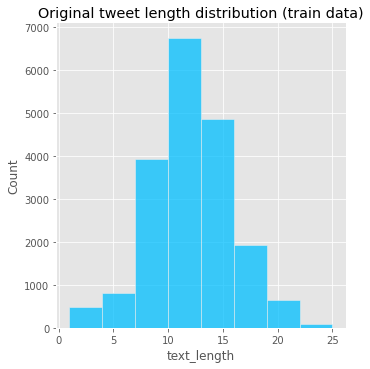

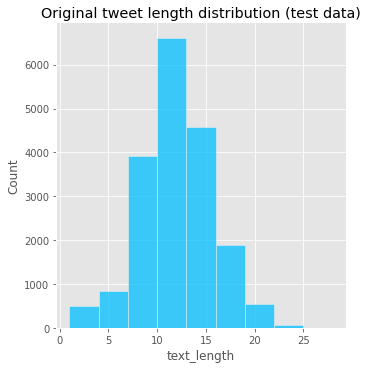

In [25]:
sns.displot(train_df, x="text_length", binwidth=3, color='deepskyblue')
plt.title("Original tweet length distribution (train data)")
plt.show()
sns.displot(test_df, x="text_length", binwidth=3, color='deepskyblue')
plt.title("Original tweet length distribution (test data)")
plt.show()

Comprobamos que la longitud de los _tweets_ se sitúa entre 1 y 25 caracteres, sin llegar siquiera a la [longitud máxima establecida por Twitter](https://developer.twitter.com/en/docs/counting-characters#:~:text=In%20most%20cases%2C%20the%20text,as%20more%20than%20one%20character.): 280.

In [ ]:
train_df[['text_length']].describe()

,text_length
count,19538.000000
mean,11.599652
std,3.691697
min,1.000000
25%,9.000000
50%,12.000000
75%,14.000000
max,25.000000


In [ ]:
test_df[['text_length']].describe()

,text_length
count,18979.000000
mean,11.507139
std,3.674756
min,1.000000
25%,9.000000
50%,11.000000
75%,14.000000
max,26.000000


__El 75 % de los tweets presentan una longitud de 14 caracteres o menos, con una longitud máxima de 25-26 caracteres__

Esta primera característica será relevante a la hora de determinar la longitud o número de tokens máximo de entrada en los modelos _transformer_ (dependiendo también de los criterios seguidos por cada _tokenizer_ )

## No obstante, algunos elementos textuales no funcionan adecuadamente en los transformers

### Emoticonos (etiquetados como [UNK] en los transformers)

In [ ]:
# -- Check if train or test DataFrames contains any emojis
train_df['has_emojis'] = train_df['postText'].apply(lambda x: any(c for c in str(x) \
                                                                  if c in emoji.UNICODE_EMOJI['en']))
test_df['has_emojis']  = test_df['postText'].apply(lambda x: any(c for c in str(x) \
                                                                 if c in emoji.UNICODE_EMOJI['en']))

# -- Check number of emojis on train and test DataFrames
train_df['n_emojis'] = train_df['postText'].apply(lambda x: len(' '.join(c for c in str(x) \
                                                                  if c in emoji.UNICODE_EMOJI['en'])))
test_df['n_emojis']  = test_df['postText'].apply(lambda x: len(' '.join(c for c in str(x) \
                                                                  if c in emoji.UNICODE_EMOJI['en'])))

#### Observamos que menos del 1 % de los tweets presenta algun emoticono, tanto en los datos de entrenamiento como _test_

In [ ]:
train_df['has_emojis'].value_counts()

False    19174
True       364
Name: has_emojis, dtype: int64

In [ ]:
test_df['has_emojis'].value_counts()

False    18636
True       343
Name: has_emojis, dtype: int64

Aunque el número de emojis no es elevado, debemos convertirlos a texto: "demoji", evitando perder posible información relevante

Ejemplo:

In [ ]:
# -- Ejemplo de demojize
emoji.demojize('Python is 👍')

'Python is :thumbs_up:'

In [28]:
train_df['postText_cleaned'] = train_df['postText'].apply(lambda x: emoji.demojize(str(x)))
test_df['postText_cleaned']  = test_df['postText'].apply(lambda x: emoji.demojize(str(x)))

### Número de _hashtags_ y menciones en los _tweets_

In [29]:
# -- Numero de hashtags en cada tweet
train_df['n_hashtags'] = train_df['postText_cleaned'].progress_apply(lambda x: len(re.findall(r'#[^ ]+', str(x))))
test_df['n_hashtags']  = test_df['postText_cleaned'].progress_apply(lambda x: len(re.findall(r'#[^ ]+', str(x))))

# -- Numero de hashtags en cada tweet
train_df['n_mentions'] = train_df['postText_cleaned'].progress_apply(lambda x: len(re.findall(r'@[^ ]+', str(x))))
test_df['n_mentions']  = test_df['postText_cleaned'].progress_apply(lambda x: len(re.findall(r'@[^ ]+', str(x))))

100%|██████████| 18979/18979 [00:00<00:00, 348903.35it/s]


#### Distribución del número de hashtags y menciones @

HASHTAGS (#)


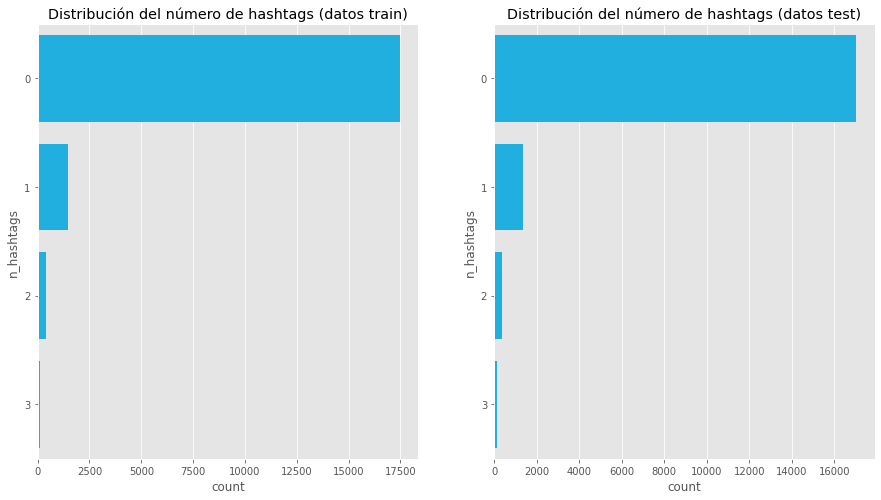


MENCIONES (@)


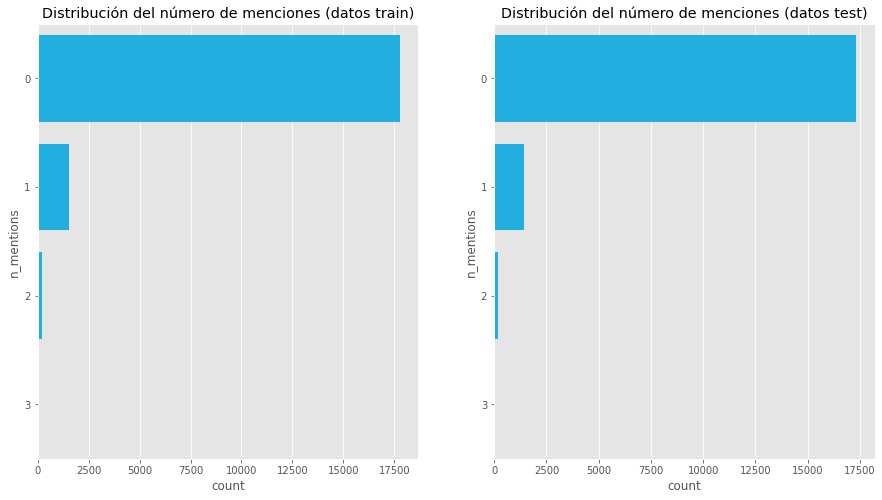

In [33]:
print("HASHTAGS (#)")
fig, axes = plt.subplots(1, 2, figsize=(15,8))
sns.countplot(data=train_df.sort_values('n_hashtags', ascending=True), 
              order=train_df.n_hashtags.value_counts().iloc[:4].index,
              y="n_hashtags", color='deepskyblue', ax=axes[0])
axes[0].set_title("Distribución del número de hashtags (datos train)")
sns.countplot(data=test_df, y="n_hashtags",
              order=test_df.n_hashtags.value_counts().iloc[:4].index,
              color='deepskyblue',ax=axes[1])
axes[1].set_title("Distribución del número de hashtags (datos test)")
plt.show()
print("\nMENCIONES (@)")
fig, axes = plt.subplots(1, 2, figsize=(15,8))
sns.countplot(data=train_df.sort_values('n_mentions', ascending=True),
              order=train_df.n_mentions.value_counts().iloc[:4].index,
              y="n_mentions", color='deepskyblue', ax=axes[0])
axes[0].set_title("Distribución del número de menciones (datos train)")
sns.countplot(data=test_df, y="n_mentions",
              order=test_df.n_mentions.value_counts().iloc[:4].index,
              color='deepskyblue',ax=axes[1])
axes[1].set_title("Distribución del número de menciones (datos test)")
plt.show()

Como podemos observar en los gráficos anteriores, tanto en entrenamiento como _test_, __la mayoría de los _tweets_ no contienen hashtags y/o menciones__.

No obstante, ¿Y si desglosamos los gráficos anteriores por la etiqueta _truthClass_? ¿Podrían las menciones y/o _hashtags_ aparecer con mayor frecuencia en los _clickbaits_?

In [ ]:
train_df["n_hashtags_cat"] = train_df["n_hashtags"].apply(lambda x: "Ningun hastag" if x == 0 else "1 o mas hashtags") 
train_df["n_mentions_cat"] = train_df["n_mentions"].apply(lambda x: "Ninguna mencion" if x == 0 else "1 o mas menciones")
test_df["n_hashtags_cat"]  = test_df["n_hashtags"].apply(lambda x: "Ningun hastag" if x == 0 else "1 o mas hashtags") 
test_df["n_mentions_cat"]  = test_df["n_mentions"].apply(lambda x: "Ninguna mencion" if x == 0 else "1 o mas menciones")

HASHTAGS (#)


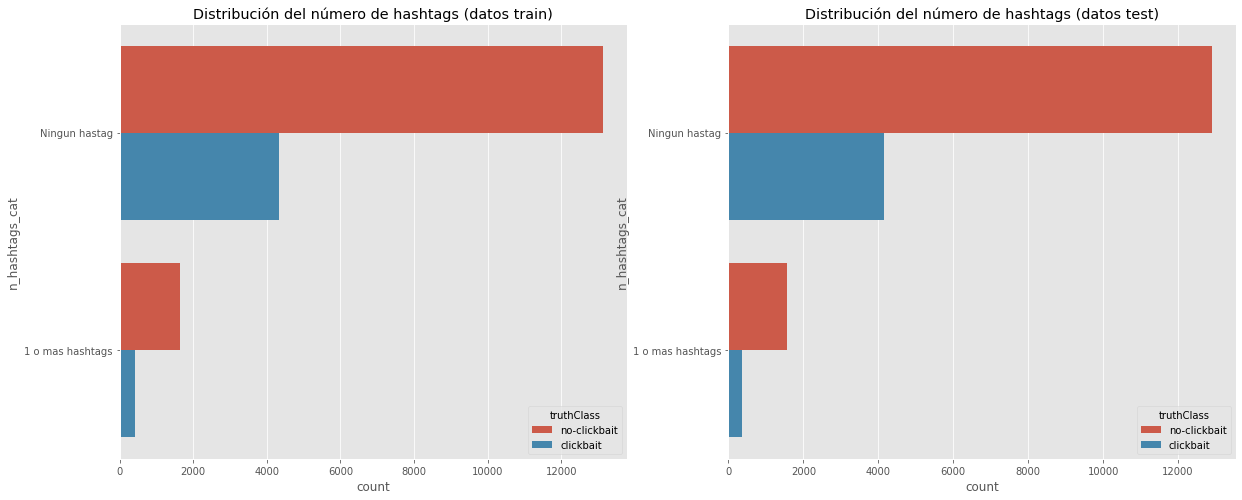


MENCIONES (@)


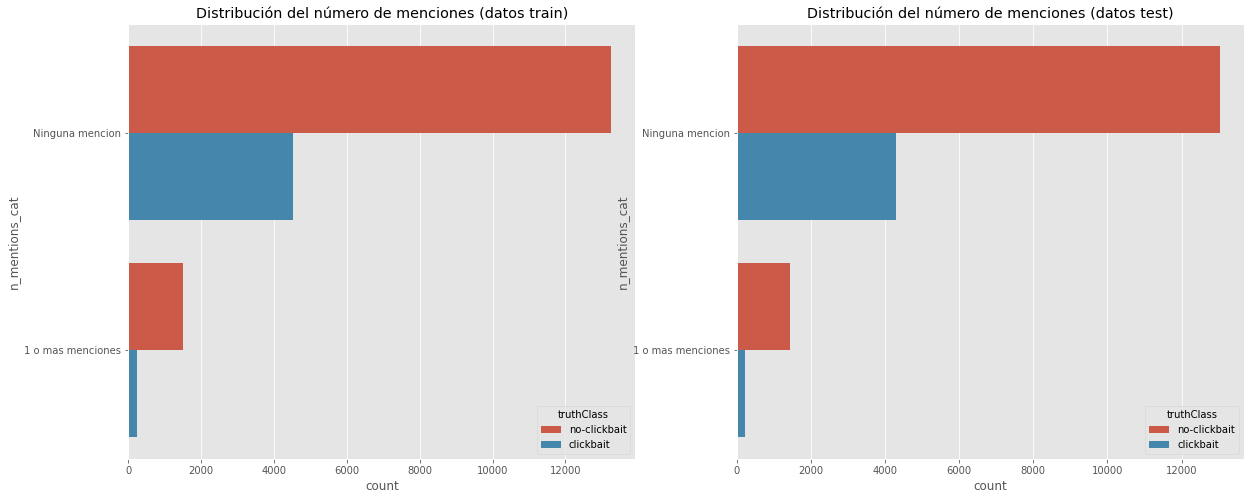

In [ ]:
print("HASHTAGS (#)")
fig, axes = plt.subplots(1, 2, figsize=(20,8), sharey=False)
sns.countplot(data=train_df.sort_values('n_hashtags_cat', ascending=False), 
              y="n_hashtags_cat", hue="truthClass", ax=axes[0])
axes[0].set_title("Distribución del número de hashtags (datos train)")
sns.countplot(data=test_df.sort_values('n_hashtags_cat', ascending=False), y="n_hashtags_cat", hue="truthClass", ax=axes[1])
axes[1].set_title("Distribución del número de hashtags (datos test)")
plt.show()
print("\nMENCIONES (@)")
fig, axes = plt.subplots(1, 2, figsize=(20,8), sharey=False)
sns.countplot(data=train_df.sort_values('n_mentions_cat', ascending=False), 
              y="n_mentions_cat", hue="truthClass", ax=axes[0])
axes[0].set_title("Distribución del número de menciones (datos train)")
sns.countplot(data=test_df.sort_values('n_mentions_cat', ascending=False), y="n_mentions_cat", 
              hue="truthClass",ax=axes[1])
axes[1].set_title("Distribución del número de menciones (datos test)")
plt.show()

Nuevamente, comprobamos que el número de hashtags y/o menciones no son especialmente relevantes, sea _clickbait_ o no.

Como consecuencia, a primera vista __no resulta primordial "limpiar" los _tweets_ de cualquier mención o _hashtag_ que pueda aportar "ruido" al modelo.__

## ¿Cuántos idiomas hay presentes en el dataset?

In [ ]:
def spacy_language_detection(text, model):
  pipeline = list(dict(model.pipeline).keys())

  if(not "language_detector" in pipeline):
    model.add_pipe(LanguageDetector(), name = "language_detector", last=True)
    
  doc = model(text)

  return doc._.language

In [ ]:
model = spacy.load("en_core_web_sm")

In [ ]:
train_df['languages_detected'] = train_df['postText_cleaned'].progress_apply(lambda x: spacy_language_detection(x, model))
test_df['languages_detected']  = test_df['postText_cleaned'].progress_apply(lambda x: spacy_language_detection(x, model))

100%|██████████| 18979/18979 [05:54<00:00, 53.55it/s]


In [ ]:
train_df['languages_detected_simplified'] = train_df['languages_detected'].progress_apply(lambda x: 'ingles' if x['language'] == 'en' else 'otros')
test_df['languages_detected_simplified']  = test_df['languages_detected'].progress_apply(lambda x: 'ingles' if x['language'] == 'en' else 'otros')

100%|██████████| 18979/18979 [00:00<00:00, 361861.30it/s]


In [ ]:
train_df.languages_detected_simplified.value_counts()

ingles    18944
otros       594
Name: languages_detected_simplified, dtype: int64

In [ ]:
test_df.languages_detected_simplified.value_counts()

ingles    18386
otros       593
Name: languages_detected_simplified, dtype: int64

Según _spacy_language_detection_, __alrededor del 3 % de los _tweets_ aparecen en otros idiomas__, aunque muchos de los detectados por SpaCy como "otros idiomas" están, en realidad, en inglés.

In [ ]:
train_df['proba'] = train_df['languages_detected'].apply(lambda x: x['score'])
test_df['proba']  = test_df['languages_detected'].apply(lambda x: x['score'])
train_df[(train_df.languages_detected_simplified != 'ingles') & \
         (train_df.postText_cleaned != 'nan')].sort_values('proba', ascending=False)

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,...,n_emojis,postText_cleaned,n_hashtags,n_mentions,n_hashtags_cat,n_mentions_cat,languages_detected,languages_detected_simplified,truthClass_numeric,proba
11930,11930,[],at long last.,852987877977882624,['Trump Appoints Religious Liberty Defender Ro...,['The New York Times recently published an art...,NYT Calls for Transgender Education in Emergen...,Fri Apr 14 20:52:12 +0000 2017,"emergency room, lgbt, New York Times, Transgen...",The New York Times published an article titled...,...,0,at long last.,0,0,Ningun hastag,Ninguna mencion,"{'language': 'tl', 'score': 0.9999991301418676}",otros,1,0.999999
7851,7851,[],good q,857702987178934272,['Report: Detroit FGM-Doctor Mutilated Girls F...,"['Radio host, author, and constitutional schol...",Mark Levin: ‘Why Aren’t the First 100 Days a M...,Thu Apr 27 21:08:22 +0000 2017,"Congress, first 100 days, Mark Levin, Presiden...",Mark Levin: ‘Why Aren’t the First 100 Days a M...,...,0,good q,0,0,Ningun hastag,Ninguna mencion,"{'language': 'so', 'score': 0.9999987834773644}",otros,1,0.999999
2669,2669,[],Waaaaahhhh!,839287741049360384,"['<> on February 16, 2017 in Washington, DC.',...",['Erik Wemple frets that the journalists taske...,WaPo: Trump May ‘Outlast’ White House Press Co...,Wed Mar 08 01:32:45 +0000 2017,",Big Government, Big Journalism,",WaPo: Trump May 'Outlast' White House Press Co...,...,0,Waaaaahhhh!,0,0,Ningun hastag,Ninguna mencion,"{'language': 'so', 'score': 0.9999985167189229}",otros,1,0.999999
15135,15135,[],Very Gen X.,817917415526989824,"['CarrieFisherProzacPillUrn', 'Arabian Gulf Wa...",['The late Hollywood actress Carrie Fisher was...,Carrie Fisher Laid to Rest in Prozac Pill Urn,Sun Jan 08 02:14:42 +0000 2017,"Carrie Fisher, Debbie Reynolds, Funeral, Proza...","The late actress's brother, Todd Fisher, said ...",...,0,Very Gen X.,0,0,Ningun hastag,Ninguna mencion,"{'language': 'de', 'score': 0.9999983982705818}",otros,1,0.999998
6025,6025,[],wat,853610333088477184,"['Easter 2017, Christians ‘Most Persecuted Gro...","['Along with Visa, Mastercard, and cash, visit...",Vatican Accepts Payment in Blood to Access Mus...,Sun Apr 16 14:05:37 +0000 2017,"Barbara Jatta, blood donors, blood drive, Cath...","Along with Visa, Mastercard, and cash, visitor...",...,0,wat,0,0,Ningun hastag,Ninguna mencion,"{'language': 'sw', 'score': 0.9999981709703253}",otros,1,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13709,13709,[],makes u think,858156127128879104,['TOPSHOT - Afghan farmers harvest opium sap f...,['WASHINGTON D.C. — The United States had the ...,GOP Lawmaker: U.S. Won’t Spray Opium in Afghan...,Sat Apr 29 03:08:59 +0000 2017,"Afghanistan, Heroin, House Foreign Affairs Com...",The United States has not sprayed opium in Afg...,...,0,makes u think,0,0,Ningun hastag,Ninguna mencion,"{'language': 'fi', 'score': 0.2857151008290221}",otros,1,0.285715
6146,6146,['media/photo_850112517351370752.jpg'],Nate Dogg's son Naijiel arrested in drug sting:,850112522673946624,"['Gavin Evans', ""LeBron James warms up by poss...","[""On Wednesday, a pair of Montana State defens...",Nate Dogg's College Football Playing Son Naiji...,Thu Apr 06 22:26:34 +0000 2017,NaN,"Naijiel Hale, the son of Nate Dogg, was arrest...",...,0,Nate Dogg's son Naijiel arrested in drug sting:,0,0,Ningun hastag,Ninguna mencion,"{'language': 'af', 'score': 0.2857136641962577}",otros,0,0.285714
9607,9607,[],2016.,809116322336538624,"['Trump Wisconsin AP', 'LA County Considers $1...",['President-elect Donald Trump’s crowd in West...,"Trump’s Wisconsin Crowd Cheers Kanye West, Boo...",Wed Dec 14 19:22:18 +0000 2016,"Donald Trump, Paul Ryan, wisconsin,2016 Presid...","Trump's Wisconsin Crowd Cheers Kanye West, Boo...",...,0,2016.,0,0,Ningun hastag,Ninguna mencion,"{'language': 'UNKNOWN', 'score': 0.0}",otros,1,0.000000
12614,12614,[],...,83490748066

# Convertimos la columna _truthClass_ a numérica

In [ ]:
train_df['truthClass_numeric'] = train_df['truthClass'].apply(lambda x: 1 if x == 'clickbait' else 0)
test_df['truthClass_numeric']  = test_df['truthClass'].apply(lambda x: 1 if x == 'clickbait' else 0)

# Finalmente, exportamos a .csv

In [ ]:
train_df[['postText_cleaned', 'truthClass_numeric']].to_csv(DATA_PATH + '/train_data_clickbait_cleaned.csv', index=False)
test_df[['postText_cleaned', 'truthClass_numeric']].to_csv(DATA_PATH + '/test_data_clickbait_cleaned.csv',   index=False)

# Entrenamiento de modelos

__NOTA__: para el entrenamiento de los modelos, y con el fin de realizar una comparación entre los diferentes candidatos, __se ha tomado la decisión de elegir las siguientes métricas__:

* __Sensibilidad o _recall_ como métrica principal__, dado el desbalanceo observado de ambas etiquetas (0,1) en ambos conjuntos (entrenamiento y _test_), lo que nos permitirá observar cuál es la probabilidad de clasificar correctamente una noticia como _clickbait_.

* Por otro lado, __la especificidad__ o probabilidad de clasificar correctamente una noticia como _non\_clickbait_

Por el contrario, otras métricas como el _AUC ROC_ pueden llevar a engaño, especialmente en _datasets_ desbalanceados.

In [4]:
train_cleaned_df = pd.read_csv(DATA_PATH + '/train_data_clickbait_cleaned.csv')
test_cleaned_df  = pd.read_csv(DATA_PATH + '/test_data_clickbait_cleaned.csv')

In [5]:
train_cleaned_df.loc[train_cleaned_df.postText_cleaned.isnull(), "postText_cleaned"] = ""
test_cleaned_df.loc[test_cleaned_df.postText_cleaned.isnull(), "postText_cleaned"] = ""

In [6]:
sep_index = train_cleaned_df.shape[0]

In [7]:
# -- Juntamos los dos DataFrames
cleaned_df = pd.concat([train_cleaned_df, test_cleaned_df], axis=0)

In [8]:
# -- Librerias para el entrenamiento/test
from transformers    import DistilBertTokenizerFast, TFDistilBertModel, DistilBertConfig, BertTokenizerFast, BertConfig, TFBertModel, RobertaTokenizerFast, TFRobertaModel, RobertaConfig
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils   import class_weight
import tensorflow    as     tf

In [9]:
# -- Constantes
BATCH_SIZE = 16                # -- Número de observaciones por cada lote o batch (por defecto, establecemos un tamaño pequeño de 16)
PADDING    = 'longest'         # -- Longitud maxima del texto (por defecto establecemos el padding de forma dinamica: el texto de mayor longitud)
TRUNCATION = True              # -- ¿Deberia truncarse aquellos textos que superen MAX_LENGTH?
RETURN_ATTENTION_MASK  = True  # -- ¿Devolvemos attention_mask del tokenizer? Lo establecemos a True
RETURN_TOKEN_TYPE_IDS  = False # -- ¿Deberia el tokenizador devolver TOKEN_TYPE_IDS? Para nuestro problema (text classification) no lo necesitariamos
LEARNING_RATE          = 2e-5  # -- Ratio de aprendizaje
RANDOM_STATE           = 1234  # -- Valor de la semilla
EPOCHS                 = 5     # -- Numero de epocas

## Primera aproximación: modelo DistilBERT (finetuning sobre la ultima capa, resto de pesos "congelados")

Como primera aproximación, se ha tomado la decisión de comenzar por una arquitectura _transformer_ sencilla, concretamente el modelo DistilBERT (con un 40 % menos de parámetros que el modelo BERT base):

Modelo menos complejo ➡ \[Si los resultados no mejoran\] ➡ Utilizar arquitecturas más complejas

In [10]:
# En primer lugar, descargamos el tokenizador del modelo DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

__No obstante, antes de elaborar cualquier modelo ¿Cual debería ser la longitud máxima de los datos de entrada?__ Dado que el modelo a emplear es DistilBERT, recuperamos el _tokenizer_ del transformer y, con ello, conocer la longitud máxima tokenizada.

In [ ]:
cleaned_df['text_tokenized_length'] = cleaned_df['postText_cleaned'].progress_apply(lambda x: len(tokenizer.encode(x)))

100%|██████████| 38517/38517 [00:11<00:00, 3290.29it/s]


In [ ]:
cleaned_df['text_tokenized_length'].max()

128

Por ende, __establecemos la longitud máxima a 128__

In [11]:
MAX_LENGTH = 128 # -- Máximo número de palabras a tokenizar

In [ ]:
cleaned_df['text_tokenized_length'] = cleaned_df['postText_cleaned'].progress_apply(lambda x: tokenizer.encode(x))

100%|██████████| 38517/38517 [00:13<00:00, 2918.58it/s]


In [12]:
# Función con la que tokenizar los textos de entrada
def construct_encodings(x, tokenizer, max_len=MAX_LENGTH, truncation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=truncation, padding=padding)

In [13]:
encodings = construct_encodings(cleaned_df['postText_cleaned'].tolist(), tokenizer)

In [14]:
# Una vez tokenizados los datos de entrada, creamos un dataset de Tensorflow
def construct_tfdataset(encodings, y=None):
    return tf.data.Dataset.from_tensor_slices((dict(encodings),y))

In [ ]:
tfdataset = construct_tfdataset(encodings, cleaned_df['truthClass_numeric'].tolist())

__Por último, creamos los conjuntos de entrenamiento y test (por lotes)__

In [ ]:
tfdataset_train = tfdataset.take(sep_index)
tfdataset_test  = tfdataset.skip(sep_index)

In [ ]:
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test  = tfdataset_test.batch(BATCH_SIZE)

__Descargamos el modelo DistilBERT base__. Inicialmente, probamos a congelar los pesos del modelo:

In [15]:
def load_distilbert(trainable=True):
  # Inicializamos el modelo
  config = DistilBertConfig(output_hidden_states=True)
                            
  # Recuperamos el modelo pre-entrenado (sin la ultima capa de clasificacion)
  distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

  # Congelamos los pesos
  for layer in distilBERT.layers:
      layer.trainable = trainable
  return distilBERT

distilBERT = load_distilbert(trainable=False)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


__Creamos la arquitectura final__

In [16]:
def build_model(transformer, max_length=MAX_LENGTH):
    # Para asegurar la reproducibilidad del modelo
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE) 
    
    # Capas de entrada
    # -- Tokens
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    # -- Attention mask
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='attention_mask', 
                                                  dtype='int32')
    
    # -- Recuperamos el "hidden-state" de la ultima capa del modelo
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # -- Recuperamos la salida del token [CLS]
    cls_token = last_hidden_state[:, 0, :]
    
    # -- Definimos la ultima capa (Dense)
    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer)(cls_token)
    
    # -- Definimos la arquitectura final
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compilamos el modelo
    # -- Metricas a emplear:
    # No solo el accuracy, sino tambien la sensibilidad o recall (pues los datos estan desbalanceados)
    # Funcion de error: binary crossentropy
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])
    
    return model

In [ ]:
model = build_model(distilBERT, max_length=MAX_LENGTH)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 128, 768),                                                   
                                 hidden_states=((No                                         

__Entrenamos el modelo__

In [ ]:
train_history = model.fit(
    tfdataset_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1
)

Epoch 1/5
1222/1222 [==============================] - 231s 172ms/step - loss: 0.5555 - accuracy: 0.7353 - recall_1: 0.0597
Epoch 2/5
1222/1222 [==============================] - 206s 168ms/step - loss: 0.4971 - accuracy: 0.7570 - recall_1: 0.0036
Epoch 3/5
1222/1222 [==============================] - 205s 168ms/step - loss: 0.4714 - accuracy: 0.7615 - recall_1: 0.0244
Epoch 4/5
1222/1222 [==============================] - 206s 169ms/step - loss: 0.4520 - accuracy: 0.7734 - recall_1: 0.0891
Epoch 5/5
1222/1222 [==============================] - 205s 168ms/step - loss: 0.4385 - accuracy: 0.7893 - recall_1: 0.1775


In [ ]:
# -- Guardamos el modelo
model.save(MODELS_PATH + '00_distilbert_first_model_frozen_layers.h5')

__Evaluamos los resultados del conjunto _test___. Para ello, utilizaremos:
* Matriz de confusión
* Valores sensibilidad/recall y especificidad

__Métricas del conjunto de entrenamiento__

In [17]:
def show_test_metrics(real_preds, test_preds_rounded, plot=True):
  cm = confusion_matrix(real_preds, test_preds_rounded,
                        labels=[0, 1])
  if plot:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Non-clickbait", "Clickbait"])
    disp.plot()
    plt.title("Matriz de confusión")
    plt.grid(b=None)
    plt.show()
  sens_clickbait     = (cm[1][1] / (cm[1][1] + cm[1][0])) * 100
  spec_non_clickbait = (cm[0][0] / (cm[0][0] + cm[0][1])) * 100
  print("Sensibilidad (clickbait): " + str(np.round(sens_clickbait, 2)) + " %")
  print("Especificidad (non-clickbait): " + str(np.round(spec_non_clickbait, 2)) + " %")

In [ ]:
test_preds = model.predict(
    tfdataset_test,
    batch_size = BATCH_SIZE,
    verbose = 1
)

1187/1187 [==============================] - 183s 152ms/step


In [ ]:
test_preds_rounded = np.round(test_preds).squeeze().astype('uint8')
real_preds         = np.array(test_cleaned_df.truthClass_numeric).astype('uint8')

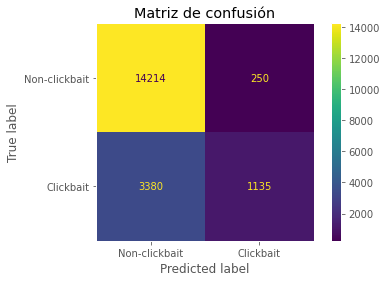

Sensibilidad (clickbait): 25.14 %
Especificidad (non-clickbait): 98.27 %


In [ ]:
show_test_metrics(real_preds, test_preds_rounded)

### Tabla de resultados

| Modelo | Arquitectura | Sensibilidad - train (clickbait) | Sensibilidad - test (clickbait) | Especificidad - test (non-clickbait) |
| -- | -- | -- | -- | -- |
| 00_distilbert_first_model_frozen_layers.h5 | DistilBERT | 0.1775 | 0.2514 | 0.9827 |

Analizando los resultados obtenidos en un primer modelo, cabe destacar __los valores bajos de sensibilidad tanto en entrenamiento como en _test___, siendo prácticamente incapaz de clasificar correctamente aquellos _tweets_ de tipo _clickbait_. 

Por otro lado ¿Y si en lugar de entrenar tan solo la última capa probamos con un fine-tuning sobre toda la arquitectura?

## Segunda aproximación: modelo DistilBERT - finetuning sobre toda la arquitectura

In [18]:
# -- Marcamos los parametros del transformer como "trainable"
distilBERT = load_distilbert(trainable=True)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model = build_model(distilBERT, max_length=MAX_LENGTH)

In [ ]:
train_history = model.fit(
    tfdataset_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1
)

Epoch 1/5
1222/1222 [==============================] - 536s 429ms/step - loss: 0.3524 - accuracy: 0.8450 - recall_1: 0.5955
Epoch 2/5
1222/1222 [==============================] - 523s 428ms/step - loss: 0.2595 - accuracy: 0.8888 - recall_1: 0.7459
Epoch 3/5
1222/1222 [==============================] - 524s 428ms/step - loss: 0.1479 - accuracy: 0.9397 - recall_1: 0.8859
Epoch 4/5
1222/1222 [==============================] - 523s 428ms/step - loss: 0.0872 - accuracy: 0.9664 - recall_1: 0.9437
Epoch 5/5
1222/1222 [==============================] - 523s 428ms/step - loss: 0.0608 - accuracy: 0.9780 - recall_1: 0.9622


In [ ]:
# -- Guardamos el modelo
model.save(MODELS_PATH + '00_distilbert_first_model.h5')

__Predicción sobre el conjunto _test___

In [ ]:
model = tf.keras.models.load_model(MODELS_PATH + '00_distilbert_first_model.h5', custom_objects={'TFDistilBertModel': distilBERT})

In [ ]:
test_preds = model.predict(
    tfdataset_test,
    batch_size = BATCH_SIZE,
    verbose = 1
)

1187/1187 [==============================] - 181s 149ms/step


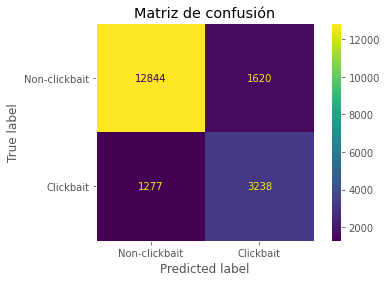

Sensibilidad (clickbait): 71.72 %
Especificidad (non-clickbait): 88.8 %


In [ ]:
show_test_metrics(real_preds, test_preds_rounded)

### Tabla de resultados

| Modelo | Arquitectura | Sensibilidad - train (clickbait) | Sensibilidad - test (clickbait) | Especificidad - test (non-clickbait) |
| -- | -- | -- | -- | -- |
| 00_distilbert_first_model_frozen_layers.h5 | DistilBERT | 0.1775 | 0.2514 | 0.9827 |
| 00_distilbert_first_model.h5 | DistilBERT | 0.9622 | 0.7172 | 0.888 |

__Primeras conclusiones__

* En comparación con el primer modelo, obtenemos una clara mejoría en los valores de sensibilidad: de 0.17 a 0.96 en entrenamiento; así como de 0.25 a 0.71 en _test_

* Pese a la mejoría, observamos un claro "sobreajuste" del modelo con respecto a los datos _test_ (de una sensibilidad del 96 % en entrenamiento frente al 71 % en _test_)

* Dado que existe un desbalanceo de la clase positiva (_clickbait_), __una posibilidad sería añadir pesos a la función de error__, penalizando de este modo la clasificación errónea (_misclassification_) sobre la clase minoritaria.

* Por otro lado, __en lugar de mantener el mismo _learning\_rate_ durante las 5 épocas de entrenamiento, una posibilidad sería reducir dicho ratio por cada época__

## Tercera aproximación: modelo DistilBERT + class weights + learning rate decay por cada época

In [ ]:
# -- Class weights
weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                            classes = np.unique(train_cleaned_df.truthClass_numeric), 
                                            y = train_cleaned_df.truthClass_numeric)

In [ ]:
weights

array([0.66109494, 2.05187986])

In [ ]:
# -- Learning rate scheduler
def scheduler(epoch, lr):
  if epoch > 0:
    return lr * 0.3
  else:
    return lr

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [ ]:
tokenizer  = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
distilBERT = load_distilbert()
model      = build_model(distilBERT, max_length=MAX_LENGTH)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: U

In [ ]:
train_history = model.fit(
    tfdataset_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = [callback],
    class_weight = {label: weight for label, weight in zip([0,1],
                                                           weights)},
    verbose = 1
)


Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/5
1222/1222 [==============================] - 507s 406ms/step - loss: 0.4272 - accuracy: 0.8028 - recall_3: 0.8202 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 5.999999848427251e-06.
Epoch 2/5
1222/1222 [==============================] - 497s 407ms/step - loss: 0.2918 - accuracy: 0.8650 - recall_3: 0.9004 - lr: 6.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7999999272433341e-06.
Epoch 3/5
1222/1222 [==============================] - 496s 405ms/step - loss: 0.2201 - accuracy: 0.8999 - recall_3: 0.9393 - lr: 1.8000e-06

Epoch 4: LearningRateScheduler setting learning rate to 5.399999849942105e-07.
Epoch 4/5
1222/1222 [==============================] - 497s 407ms/step - loss: 0.1927 - accuracy: 0.9128 - recall_3: 0.9496 - lr: 5.4000e-07

Epoch 5: LearningRateScheduler setting learning rate to 1.6199999208765803e-07.
Epoch 5/5
1222/1222 [============

In [ ]:
# -- Guardamos el modelo
model.save(MODELS_PATH + '00_distilbert_first_model_class_weights_lr_scheduler.h5')

In [ ]:
model = tf.keras.models.load_model(MODELS_PATH + '00_distilbert_first_model_class_weights_lr_scheduler.h5', custom_objects={'TFDistilBertModel': distilBERT})

__Predicción sobre el conjunto _test___

In [ ]:
test_preds = model.predict(
    tfdataset_test,
    batch_size = BATCH_SIZE,
    verbose = 1
)

1187/1187 [==============================] - 186s 152ms/step


In [ ]:
test_preds_rounded = np.round(test_preds).squeeze().astype('uint8')
real_preds         = np.array(test_cleaned_df.truthClass_numeric).astype('uint8')

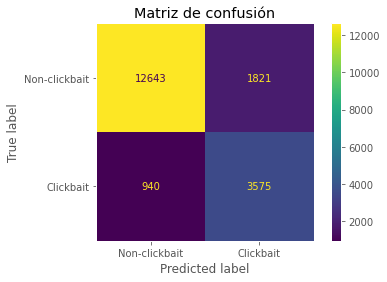

Sensibilidad (clickbait): 79.18 %
Especificidad (non-clickbait): 87.41 %


In [ ]:
show_test_metrics(real_preds, test_preds_rounded)

### Tabla de resultados

| Modelo | Arquitectura | Sensibilidad - train (clickbait) | Sensibilidad - test (clickbait) | Especificidad - test (non-clickbait) |
| -- | -- | -- | -- | -- |
| 00_distilbert_first_model_frozen_layers.h5 | DistilBERT | 0.1775 | 0.2514 | 0.9827 |
| 00_distilbert_first_model.h5 | DistilBERT | 0.9622 | 0.7172 | 0.888 |
| 00_distilbert_first_model_class_weights_lr_scheduler.h5 | DistilBERT | 0.9515 | 0.7918 | 0.8741 |

__Conclusiones:__

* En base a los nuevos resultados, observamos que __la tasa de sensibilidad ha mejorado en torno al 10 %__, mientras que la especificidad se ha mantenido con un valor similar (apenas reduce de 0.88 a 0.87)

* Pese a la mejoría, el modelo continua presentando cierto sobreajuste entre los datos de entrenamiento y _test_.

* Dado el sobreajuste, otra posibilidad sería __reducir el número de épocas de 5 a 2__, por ejemplo.

## Cuarta aproximación: modelo DistilBERT + class weights + learning rate decay por cada época + reducción del número de épocas a 2

In [ ]:
EPOCHS = 2

In [ ]:
# -- Class weights
weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                            classes = np.unique(train_cleaned_df.truthClass_numeric), 
                                            y = train_cleaned_df.truthClass_numeric)

In [ ]:
weights

array([0.66109494, 2.05187986])

In [ ]:
# -- Learning rate scheduler
def scheduler(epoch, lr):
  if epoch > 0:
    return lr * 0.3
  else:
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [ ]:
tokenizer  = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
distilBERT = load_distilbert()
model      = build_model(distilBERT, max_length=MAX_LENGTH)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: U

In [ ]:
train_history = model.fit(
    tfdataset_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = [callback],
    class_weight = {label: weight for label, weight in zip([0,1],
                                                           weights)},
    verbose = 1
)


Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/2
1222/1222 [==============================] - 507s 406ms/step - loss: 0.4261 - accuracy: 0.8070 - recall_1: 0.8101 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 5.999999848427251e-06.
Epoch 2/2
1222/1222 [==============================] - 495s 405ms/step - loss: 0.2929 - accuracy: 0.8642 - recall_1: 0.9009 - lr: 6.0000e-06


In [ ]:
# -- Guardamos el modelo
model.save(MODELS_PATH + '00_distilbert_first_model_class_weights_lr_scheduler_red_num_epochs.h5')

In [ ]:
model = tf.keras.models.load_model(MODELS_PATH + '00_distilbert_first_model_class_weights_lr_scheduler_red_num_epochs.h5', custom_objects={'TFDistilBertModel': distilBERT})

__Predicción sobre el conjunto _test___

In [ ]:
test_preds = model.predict(
    tfdataset_test,
    batch_size = BATCH_SIZE,
    verbose = 1
)

1187/1187 [==============================] - 174s 145ms/step


In [ ]:
test_preds_rounded = np.round(test_preds).squeeze().astype('uint8')
real_preds         = np.array(test_cleaned_df.truthClass_numeric).astype('uint8')

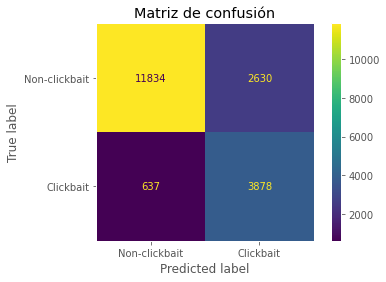

Sensibilidad (clickbait): 85.89 %
Especificidad (non-clickbait): 81.82 %


In [ ]:
show_test_metrics(real_preds, test_preds_rounded)

### Tabla de resultados

| Modelo | Arquitectura | Sensibilidad - train (clickbait) | Sensibilidad - test (clickbait) | Especificidad - test (non-clickbait) |
| -- | -- | -- | -- | -- |
| 00_distilbert_first_model_frozen_layers.h5 | DistilBERT | 0.1775 | 0.2514 | 0.9827 |
| 00_distilbert_first_model.h5 | DistilBERT | 0.9622 | 0.7172 | 0.888 |
| 00_distilbert_first_model_class_weights_lr_scheduler.h5 | DistilBERT | 0.9515 | 0.7918 | 0.8741 |
| 00_distilbert_first_model_class_weights_lr_scheduler_red_num_epochs.h5 | DistilBERT | 0.9009 | 0.8589 | 0.8182 |

__Conclusiones__:

* Tras reducir el número de épocas a 2, __comprobamos que la diferencia entre los valores de sensibilidad, tanto entrenamiento como en _test_, se ha reducido__ (0.90 y 0.85, respectivamente).

* En relación con la especificidad, pese a disminuir de 0.87-0.88 a 0.81 continua situandose por encima de 0.8

Por otro lado, dado que esta configuración ha proporcionado buenos resultados __¿Y si reemplazamos el modelo DistillBERT por otra arquitectura más compleja, concretamente el modelo BERT original?__

## Quinta aproximación: modelo BERT original + configuración 4ª aproximación

__Como última comparación, realizamos un fine-tuning con la arquitectura BERT original__, con la misma configuración que en la tercera aproximación: _learning rate_, número de épocas, así como _class weights_

In [ ]:
# Descargamos el tokenizador del modelo BERT
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

__¿Cuál debería ser la longitud máxima?__

In [ ]:
cleaned_df['text_tokenized_length'] = cleaned_df['postText_cleaned'].progress_apply(lambda x: len(tokenizer.encode(x)))

100%|██████████| 38517/38517 [00:05<00:00, 7257.88it/s]


In [ ]:
cleaned_df['text_tokenized_length'].max()

128

In [ ]:
MAX_LENGTH = 128               # -- Máximo número de palabras a tokenizar

Configuración y creación del _dataset_

In [ ]:
encodings = construct_encodings(cleaned_df['postText_cleaned'].tolist(), tokenizer)
tfdataset = construct_tfdataset(encodings, cleaned_df['truthClass_numeric'].tolist())

In [ ]:
tfdataset_train = tfdataset.take(sep_index)
tfdataset_test  = tfdataset.skip(sep_index)
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test  = tfdataset_test.batch(BATCH_SIZE)

Descargamos el modelo BERT

In [ ]:
# Inicializamos el modelo
config = BertConfig(output_hidden_states=True)
                            
# Recuperamos el modelo pre-entrenado (sin la ultima capa de clasificacion)
bert   = TFBertModel.from_pretrained('bert-base-uncased', config=config)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = build_model(bert, max_length=MAX_LENGTH)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

Configuración pesos + función de error

In [ ]:
# -- Class weights
weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                            classes = np.unique(train_cleaned_df.truthClass_numeric), 
                                            y = train_cleaned_df.truthClass_numeric)
# -- Learning rate scheduler
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [ ]:
train_history = model.fit(
    tfdataset_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = [callback],
    class_weight = {label: weight for label, weight in zip([0,1],
                                                           weights)},
    verbose = 1
)


Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1222/1222 [==============================] - 1048s 838ms/step - loss: 0.4287 - accuracy: 0.8012 - recall: 0.8227 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 5.999999848427251e-06.
Epoch 2/2
1222/1222 [==============================] - 1025s 839ms/step - loss: 0.2802 - accuracy: 0.8685 - recall: 0.9053 - lr: 6.0000e-06


In [ ]:
model.save(MODELS_PATH + '00_bert_first_model_class_weights_lr_scheduler_red_num_epochs.h5')

In [ ]:
test_preds = model.predict(
    tfdataset_test,
    batch_size = BATCH_SIZE,
    verbose = 1
)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1187/1187 [==============================] - 369s 308ms/step


In [ ]:
test_preds_rounded = np.round(test_preds).squeeze().astype('uint8')
real_preds         = np.array(test_cleaned_df.truthClass_numeric).astype('uint8')

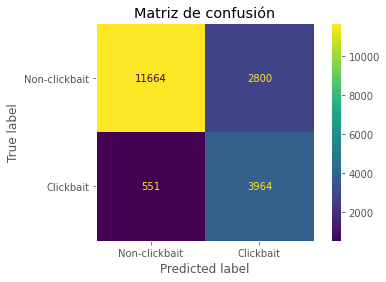

Sensibilidad (clickbait): 87.8 %
Especificidad (non-clickbait): 80.64 %


In [ ]:
show_test_metrics(real_preds, test_preds_rounded)

### Tabla de resultados

| Modelo | Arquitectura | Sensibilidad - train (clickbait) | Sensibilidad - test (clickbait) | Especificidad - test (non-clickbait) |
| -- | -- | -- | -- | -- |
| 00_distilbert_first_model_frozen_layers.h5 | DistilBERT | 0.1775 | 0.2514 | 0.9827 |
| 00_distilbert_first_model.h5 | DistilBERT | 0.9622 | 0.7172 | 0.888 |
| 00_distilbert_first_model_class_weights_lr_scheduler.h5 | DistilBERT | 0.9515 | 0.7918 | 0.8741 |
| 00_distilbert_first_model_class_weights_lr_scheduler_red_num_epochs.h5 | DistilBERT | 0.9009 | 0.8589 | 0.8182 |
| 00_bert_first_model_class_weights_lr_scheduler_red_num_epochs.h5 | BERT | 0.9053 | 0.878 | 0.8064 |

Tras evaluar los resultados sobre el conjunto _test_, pese a emplear un modelo más complejo:


| Modelo | Número de parámetros (millones) | 
| -- | -- |
| arquitectura con DistilBERT | ~66 M |
| arquitectura con BERT original | ~109 M | 

la mejoría es de tan solo dos décimas. No obstante, y como última prueba, probamos con otra arquitectura más compleja que DistilBERT: RoBERTa, cuya arquitectura y funcionamiento es similar al modelo BERT, aunque con ciertas diferencias, como es el uso del _dynamic masking_.

## Sexta aproximación: modelo RoBERTa + configuración 4ª aproximación

In [ ]:
# Descargamos el tokenizador del modelo RoBERTa
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

__¿Cuál debería ser la longitud máxima?__

In [ ]:
cleaned_df['text_tokenized_length'] = cleaned_df['postText_cleaned'].progress_apply(lambda x: len(tokenizer.encode(x)))

100%|██████████| 38517/38517 [00:06<00:00, 5832.10it/s]


In [ ]:
cleaned_df.text_tokenized_length.max()

157

In [ ]:
MAX_LENGTH = 128               # -- Máximo número de palabras a tokenizar

Configuración y creación del _dataset_

In [ ]:
encodings = construct_encodings(cleaned_df['postText_cleaned'].tolist(), tokenizer)
tfdataset = construct_tfdataset(encodings, cleaned_df['truthClass_numeric'].tolist())

In [ ]:
tfdataset_train = tfdataset.take(sep_index)
tfdataset_test  = tfdataset.skip(sep_index)
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test  = tfdataset_test.batch(BATCH_SIZE)

Descargamos el modelo BERT

In [ ]:
# Recuperamos el modelo pre-entrenado (sin la ultima capa de clasificacion)
roberta= TFRobertaModel.from_pretrained('roberta-base', config=config)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
model = build_model(roberta, max_length=MAX_LENGTH)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

Configuración pesos + función de error

In [ ]:
# -- Class weights
weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                            classes = np.unique(train_cleaned_df.truthClass_numeric), 
                                            y = train_cleaned_df.truthClass_numeric)
# -- Learning rate scheduler
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [ ]:
train_history = model.fit(
    tfdataset_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = [callback],
    class_weight = {label: weight for label, weight in zip([0,1],
                                                           weights)},
    verbose = 1
)


Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/2
1222/1222 [==============================] - 1021s 815ms/step - loss: 0.4329 - accuracy: 0.8028 - recall: 0.8200 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 5.999999848427251e-06.
Epoch 2/2
1222/1222 [==============================] - 990s 810ms/step - loss: 0.3048 - accuracy: 0.8620 - recall: 0.8939 - lr: 6.0000e-06


In [ ]:
model.save(MODELS_PATH + '00_roberta_first_model_class_weights_lr_scheduler_red_num_epochs.h5')

In [ ]:
test_preds = model.predict(
    tfdataset_test,
    batch_size = BATCH_SIZE,
    verbose = 1
)

1187/1187 [==============================] - 350s 291ms/step


In [ ]:
test_preds_rounded = np.round(test_preds).squeeze().astype('uint8')
real_preds         = np.array(test_cleaned_df.truthClass_numeric).astype('uint8')

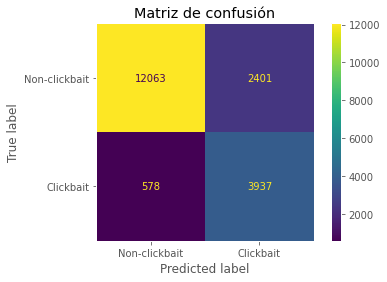

Sensibilidad (clickbait): 87.2 %
Especificidad (non-clickbait): 83.4 %


In [ ]:
show_test_metrics(real_preds, test_preds_rounded)

### Tabla de resultados

| Modelo | Arquitectura | Sensibilidad - train (clickbait) | Sensibilidad - test (clickbait) | Especificidad - test (non-clickbait) |
| -- | -- | -- | -- | -- |
| 00_distilbert_first_model_frozen_layers.h5 | DistilBERT | 0.1775 | 0.2514 | 0.9827 |
| 00_distilbert_first_model.h5 | DistilBERT | 0.9622 | 0.7172 | 0.888 |
| 00_distilbert_first_model_class_weights_lr_scheduler.h5 | DistilBERT | 0.9515 | 0.7918 | 0.8741 |
| 00_distilbert_first_model_class_weights_lr_scheduler_red_num_epochs.h5 | DistilBERT | 0.9009 | 0.8589 | 0.8182 |
| 00_bert_first_model_class_weights_lr_scheduler_red_num_epochs.h5 | BERT | 0.9053 | 0.878 | 0.8064 |
| 00_roberta_first_model_class_weights_lr_scheduler_red_num_epochs.h5 | RoBERTa | 0.8939 | 0.872 | 0.834 |

Nuevamente, y al igual que con la arquitectura BERT, pese a ser un modelo más complejo:

| Modelo | Número de parámetros (millones) | 
| -- | -- |
| arquitectura con DistilBERT | ~66 M |
| arquitectura con BERT original | ~109 M |
| arquitectura con RoBERTa | ~124 M |

La sensibilidad apenas mejora en dos décimas con respecto a la arquitectura DistilBERT.

# Conclusión final

Tras realizar diferentes pruebas sobre el _dataset_ proporcionado, es momento de realizar la siguiente pregunta: __¿Qué modelo debemos escoger?__ En base a los resultados empíricos de la tabla, podrían ser:

1. DistilBERT con _class weights_, _lr\_scheduler_ (2 épocas)
2. BERT (mismas características)
3. RoBERTa (mismas características)

Es decir, los modelos con los valores de sensibilidad más elevados. No obstante, pese a que los modelos BERT y RoBERTa mejoran con respecto a la arquitectura DistilBERT, __tan solo es de 2 décimas pese a tener más de 40 y 60 millones de parámetros adicionales__, respectivamente (diferencia que incluso puede deberse a cuestiones meramente azarosas como el valor de la semilla inicial).

Como consecuencia, __aplicando el principio de parsimonia (ante varios sucesos en igualdad de condiciones, la explicación más sencilla suele ser la más probable), nos decantamos por la arquitectura con menos parámetros: DistilBERT__

Modelo escogido:

| Modelo | Arquitectura | Sensibilidad - train (clickbait) | Sensibilidad - test (clickbait) | Especificidad - test (non-clickbait) |
| -- | -- | -- | -- | -- |
| 00_distilbert_first_model_class_weights_lr_scheduler_red_num_epochs.h5 | DistilBERT | 0.9009 | 0.8589 | 0.8182 |

De forma adicional y como futuras líneas de análisis, otra posibilidad podría ser __plantear otras arquitecturas más sencillas como redes LSTM__.

# Análisis de errores

Tras seleccionar el modelo final, el último paso consiste en analizar algunas de las predicciones del modelo, con el propóstito de comprobar __cuándo/cómo o porqué el algoritmo falla__.

Para ello, cargamos el modelo y las predicciones:

In [19]:
model = tf.keras.models.load_model(MODELS_PATH + '00_distilbert_first_model_class_weights_lr_scheduler_red_num_epochs.h5', custom_objects={'TFDistilBertModel': distilBERT})

__Predicción sobre el conjunto _test___

In [ ]:
test_preds = model.predict(
    tfdataset_test,
    batch_size = BATCH_SIZE,
    verbose = 1
)

1187/1187 [==============================] - 85s 70ms/step


In [ ]:
test_preds_rounded = np.round(test_preds).squeeze().astype('uint8')
test_preds         = test_preds.squeeze()
real_preds         = np.array(test_cleaned_df.truthClass_numeric).astype('uint8')

In [ ]:
# -- Guardamos test_preds_rounded y real_preds en ficheros numpy para su uso posterior
np.save('/content/drive/MyDrive/Personal/Clickbait/data/test_preds_rounded.npz', test_preds_rounded)
np.save('/content/drive/MyDrive/Personal/Clickbait/data/test_preds.npz', test_preds)
np.save('/content/drive/MyDrive/Personal/Clickbait/data/real_preds.npz', real_preds)

In [20]:
# -- Cargamos test_preds_rounded y real_preds en ficheros numpy para su uso posterior
test_preds_rounded = np.load('/content/drive/MyDrive/Personal/Clickbait/data/test_preds_rounded.npz.npy')
test_preds = np.load('/content/drive/MyDrive/Personal/Clickbait/data/test_preds.npz.npy')
real_preds = np.load('/content/drive/MyDrive/Personal/Clickbait/data/real_preds.npz.npy')

In [21]:
# Creamos una nueva columna en el DataFrame test con la probabilidad
test_cleaned_df["proba"] = test_preds

In [22]:
test_cleaned_df.head()

,postText_cleaned,truthClass_numeric,proba
0,Johnny Manziel on Browns' No. 1 pick Myles Gar...,0,0.004322
1,Fabio: California Is a 'Mess' Because of Liber...,0,0.008683
2,"""He's been huge for us this year, man.""",1,0.958037
3,New Bears quarterback Mitchell Trubisky was gr...,0,0.015746
4,It's not enough to let employees work flexible...,0,0.553662


## Distribución de los valores de probabilidad

![Imagen ejemplo](https://i0.wp.com/neptune.ai/wp-content/uploads/error-analysis-text.png?resize=512%2C288&ssl=1)

En primer lugar, una pregunta que podemos hacernos es: __¿El conjunto _test_ es fácil de etiquetar por el modelo? Dicho de otro modo: los valores de probabilidad obtenidos tras el _predict_ ¿Tienden hacia extremos \[0,1\], o por el contrario se sitúan en torno a 0.5?__

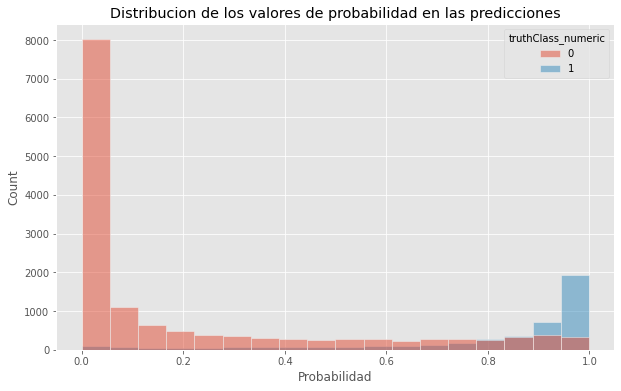

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=test_cleaned_df, x="proba", hue="truthClass_numeric")
plt.xlabel("Probabilidad")
plt.title("Distribucion de los valores de probabilidad en las predicciones")
plt.show()

Como podemos observar en el gráfico de distribución anterior, __la mayoría de los _tweets_ presentan valores de probabilidad muy cercanos a 0 o 1__: aparentemente, se trata de un conjunto "fácil" de clasificar. De hecho, si analizamos los percentiles de cada clase:

In [ ]:
test_cleaned_df[test_cleaned_df["truthClass_numeric"] == 1]["proba"].describe()

count    4515.000000
mean        0.801880
std         0.259112
min         0.000940
25%         0.750370
50%         0.922050
75%         0.974910
max         0.998958
Name: proba, dtype: float64

Comprobamos que, gracias al primer cuartil, __menos del 25 % de las tweets _clickbait_ presentan una probabilidad igual o inferior a 0.75__

In [ ]:
test_cleaned_df[test_cleaned_df["truthClass_numeric"] == 0]["proba"].describe()

count    14464.000000
mean         0.201975
std          0.292887
min          0.000162
25%          0.004500
50%          0.034778
75%          0.306132
max          0.995188
Name: proba, dtype: float64

__Del mismo modo, en aquellos _tweets_ _no\_clickbait_, tan solo un 25 % presentan una probabilidad igual o superior a 0.30 (ver percentil 75)__

Es decir, a simple vista el modelo es capaz de simplificar los _tweets_ con un elevado valor de probabilidad. No obstante, algunas de estas clasificaciones son erróneas. Analicemos el porqué.

## Longitud de los tweets

Otro aspecto por analizar sería la longitud de los _tweets_: ya sea en los falsos positivos como negativos, __¿El modelo puede estar fallando con los _tweets_ con menos caracteres?__

In [ ]:
test_cleaned_df['text_length'] = test_cleaned_df['postText_cleaned'].apply(lambda x: len(str(x).split()))

In [ ]:
test_cleaned_df['clickbait_false_positive'] = test_cleaned_df.apply(lambda x: "Falso positivo" if x["truthClass_numeric"] == 0 and \
                                                                    x["proba"] >= 0.5 else "Falso negativo" if x["truthClass_numeric"] == 1 and \
                                                                    x["proba"] < 0.5 else "Prediccion correcta", axis=1)

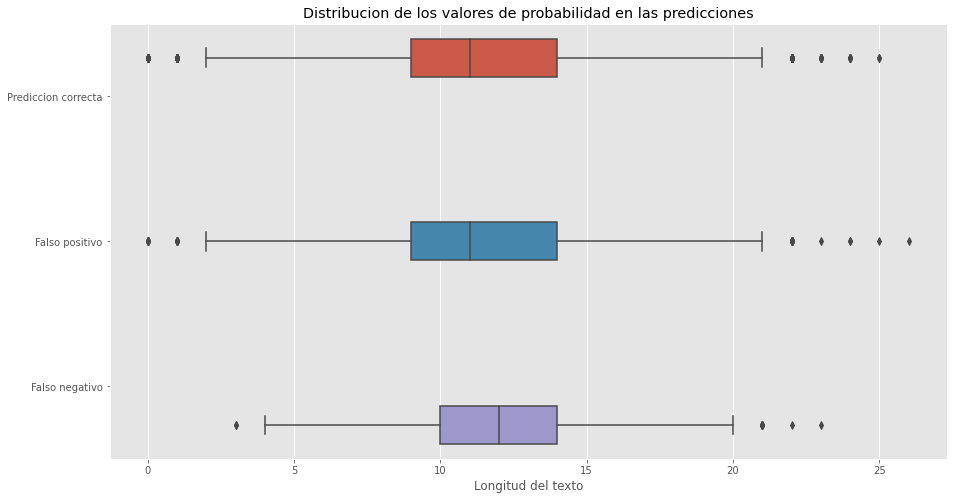

In [ ]:
# -- A traves de un boxplot, mostramos la distribucion de prob. por cada tipo de prediccion
plt.figure(figsize=(15,8))
sns.boxplot(data=test_cleaned_df, x="text_length", 
            hue="clickbait_false_positive", y="clickbait_false_positive")
plt.xlabel("Longitud del texto")
plt.ylabel("")
plt.title("Distribucion de los valores de probabilidad en las predicciones")
plt.legend([],[], frameon=False)
plt.show()

Como podemos observar en el diagrama de cajas anterior, no parece aportar información sobre los fallos en algunas de las predicciones: __del mismo modo que algunos _tweets_ de "menor longitud" son clasificados erróneamente, también sucede con _tweets_ de "mayor longitud"__.

## Shap explainer

Tras comprobar que, aparentemente, la longitud de los _tweets_ no es un factor relevante a la hora de determinar posibles fallos en las predicciones, aún queda una pregunta muy importante ¿Qué caracteres tienen una mayor influencia en las predicciones sobre el modelo? Es decir, ¿Y si sobre la prediccion influyen caracteres de poca o ninguna relevancia?

Para comprobarlo, utilizaremos unas de las librerias (junto con LIME) de _Explainable AI_ más importantes: SHAP

In [23]:
# -- Librerias
import scipy as sp
import warnings
import pickle
import shap
shap.initjs()

warnings.filterwarnings("ignore")

In [146]:
# -- Definimos la funcion con la que calcular el score del shap.Explainer
#    Fuente: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/text.html
def f(x):
  x = list(x)
  encodings = construct_encodings(x, tokenizer)
  tfdataset = construct_tfdataset(encodings)
  outputs   = model.predict(tfdataset)
  val       = sp.special.logit(outputs) 
  return val
    
explainer = shap.Explainer(f,tokenizer,output_names=["Clickbait"])

### Falsos positivos

En primer lugar, comencemos con los falsos positivos: _tweets_ de tipo _no clickbait_, pero etiquetados como _clickbait_. Para ello, __del conjunto _test_ recuperamos una muestra, conformada por las 200 predicciones con mayor probabilidad (superior al 90 %), es decir, analizamos los casos más extremos de falsos postivos__. 

In [25]:
top_bad_pred_non_clickbait = test_cleaned_df[(test_cleaned_df["truthClass_numeric"] == 0) &\
                                             (test_cleaned_df["proba"] >= 0.9)].sort_values("proba", ascending=False).head(n=200)
top_bad_pred_non_clickbait.reset_index(drop=True, inplace=True)

In [ ]:
shap_values_list_aux = explainer(top_bad_pred_non_clickbait['postText_cleaned'].reset_index(drop=True))
with open('/content/drive/MyDrive/Personal/Clickbait/data/shap_explainer_false_positive.pkl', 'wb') as f:
  pickle.dump(shap_values_list_aux, f)

In [41]:
with open('/content/drive/MyDrive/Personal/Clickbait/data/shap_explainer_false_positive.pkl', 'rb') as f:
  shap_values_list_aux = pickle.load(f)

Tras calcular los _shap values_, __creamos un DataFrame con el que almacenar el shap_value máximo (es decir, el score máximo) de cada término__:

In [42]:
# -- shap_values_list_aux almacena una array de arrays, uno por cada tweet. Por ello, convertimos dicho array de 2-D en una
#    sola dimension (flatten) 
shap_values_list_aux.values = np.concatenate(shap_values_list_aux.values, axis=0)
shap_values_list_aux.data   = np.concatenate(shap_values_list_aux.data, axis=0)
shap_values_list_aux.data   = np.array(list(map(lambda x: x.capitalize(), shap_values_list_aux.data)))
features_importance_dataset_max = pd.DataFrame({'array': shap_values_list_aux.values.squeeze(),
                                                'data': shap_values_list_aux.data.squeeze()}).groupby('data').max().reset_index()

In [80]:
# -- Filtramos aquellos elementos con un score maximo de 1.2 (lo mas relevantes)
features_importance_dataset_max_df = features_importance_dataset_max[features_importance_dataset_max.array > 1.2]\
                                                                     .sort_values("array", ascending=True)
features_importance_dataset_max_df['color'] = features_importance_dataset_max_df.data.apply(lambda x: 'orange' if\
                                                                    x in ["We", ".", ":", "!", "Why", "This"] else "deepskyblue")

Una vez recuperados los pesos maximos, a través de un gráfico de barras __mostramos algunos de los elementos de mayor peso__:

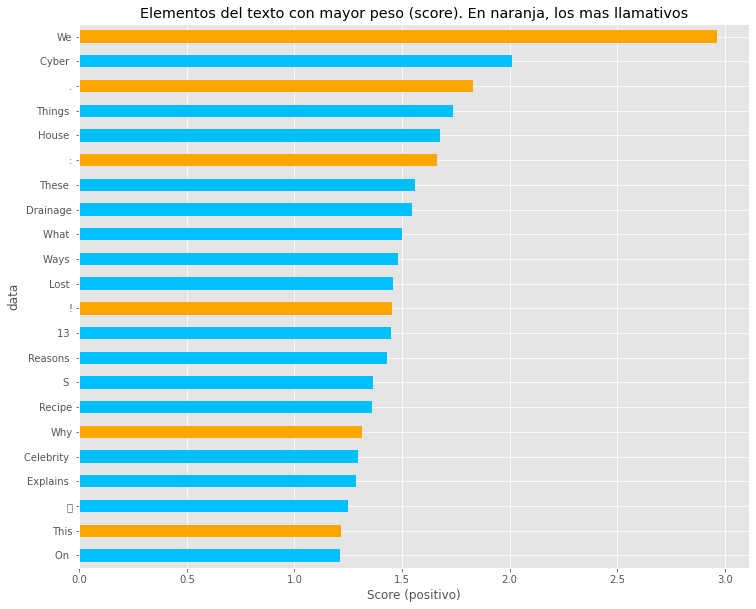

In [81]:
features_importance_dataset_max_df.plot(kind='barh', y='array', x='data', 
                                        color= features_importance_dataset_max_df['color'], legend=False, figsize=(12, 10))
plt.title("Elementos del texto con mayor peso (score). En naranja, los mas llamativos")
plt.xlabel("Score (positivo)")
plt.show()

Como podemos comprobar en el gráfico anterior (resaltando en naranja algunos de los más llamativos), __algunas de las expresiones de mayor peso corresponden con signos de puntuación, pronombres como _We_ o _This_ e incluso _WH-questions_ como _Why_ o _What___. Es decir, en algunos _tweets_ "presta más atención" a determinantes, pronombres o elementos exclamativos, en lugar de sustantivos, adjetivos o verbos. Para muestra un botón:

In [93]:
test_cleaned_df_filtered = test_cleaned_df[(test_cleaned_df.postText_cleaned.str.contains(r"\bWe\b", regex=True)) &\
                                           (test_cleaned_df.truthClass_numeric == 0) & (test_cleaned_df.proba >= 0.5)].sort_values('proba', ascending=False)

In [ ]:
shap_values = explainer(list(test_cleaned_df_filtered.head(n=3)['postText_cleaned']))

In [96]:
for explainer_values in shap_values:
  shap.text_plot(explainer_values)

Como primera conclusión del "análisis de errores": dado que algunos de estos caracteres corresponden con signos de puntuación, una posible mejora podría ser __eliminando dichos signos de puntuación, e incluso los emoticonos ya que, si recordamos del apartado de _Exploratory Data Analysis_, el formato con el que se codifican es :nombre_emoji:__, lo cual puede estar aportando ruido al modelo.

### Falsos negativos

Por otro lado, analicemos los errores que suceden con falsos negativos. Nuevamente, __recuperamos las primeras 200 predicciones erróneas__:

In [97]:
top_bad_pred_clickbait = test_cleaned_df[(test_cleaned_df["truthClass_numeric"] == 1) &\
                                             (test_cleaned_df["proba"] < 0.4)].sort_values("proba", ascending=False).head(n=200)
top_bad_pred_clickbait.reset_index(drop=True, inplace=True)

In [ ]:
shap_values_list_aux = explainer(top_bad_pred_clickbait['postText_cleaned'].reset_index(drop=True))
with open('/content/drive/MyDrive/Personal/Clickbait/data/shap_explainer_false_negative.pkl', 'wb') as f:
  pickle.dump(shap_values_list_aux, f)

In [98]:
with open('/content/drive/MyDrive/Personal/Clickbait/data/shap_explainer_false_negative.pkl', 'rb') as f:
  shap_values_list_aux = pickle.load(f)

In [99]:
shap_values_list_aux.values = np.concatenate(shap_values_list_aux.values, axis=0)
shap_values_list_aux.data   = np.concatenate(shap_values_list_aux.data, axis=0)
shap_values_list_aux.data   = np.array(list(map(lambda x: x.capitalize(), shap_values_list_aux.data)))
features_importance_dataset_max = pd.DataFrame({'array': shap_values_list_aux.values.squeeze(),
                                                'data': shap_values_list_aux.data.squeeze()}).groupby('data').max().reset_index()

Una vez recuperados los correspondientes _shap values_, __analicemos cuales son los caracteres/elementos con mayor peso negativo, es decir, caracteres que inluyan al modelo a clasificar el _tweet_ como _no clickbait___:

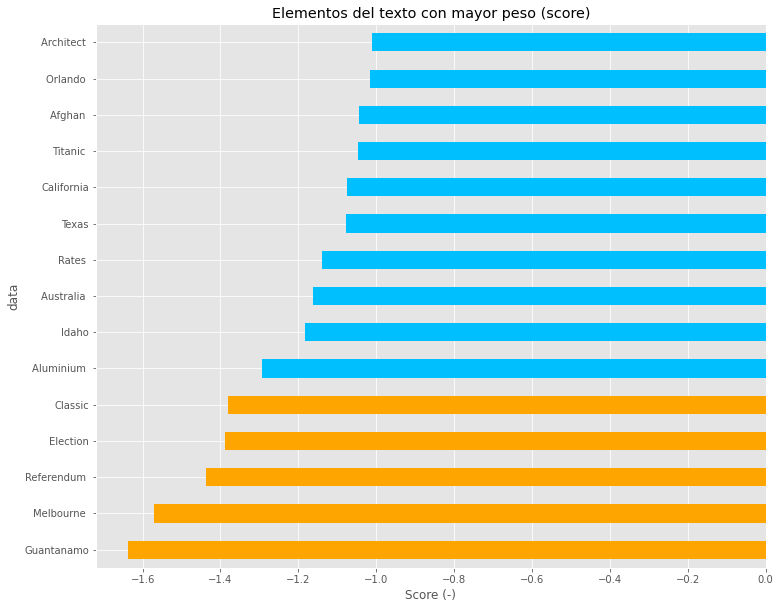

In [109]:
# -- Filtramos aquellos elementos con un score minimo de -1 (lo mas relevantes en "sentido negativo")
features_importance_dataset_max[features_importance_dataset_max.array < -1]\
                    .sort_values("array", ascending=True).plot(kind='barh', y='array', x='data', 
                                 color=['orange'] * 5 +  ['deepskyblue'] * 21, legend=False, figsize=(12, 10))
plt.title("Elementos del texto con mayor peso (score)")
plt.xlabel("Score (-)")
plt.show()

Como podemos observar en el gráfico anterior, algunos de los caracteres más relevantes (marcados en __naranja__) son sustantivos como _Guantanamo_, _Melbourne_, _Referendum_, _Election_ y _Classic_, en lugar de signos de puntuación o pronombres como es el caso de algunos falsos positivos.

Sin embargo, si analizamos el siguiente gráfico de barras:

In [102]:
freq_words_dict = {}
for char in features_importance_dataset_max[features_importance_dataset_max.array < -1]\
                    .sort_values("array", ascending=True).data:
  freq_words_dict[char] = train_cleaned_df[train_cleaned_df["postText_cleaned"]\
                                            .str.contains(char, case=False)]["truthClass_numeric"]\
                                            .value_counts().tolist()

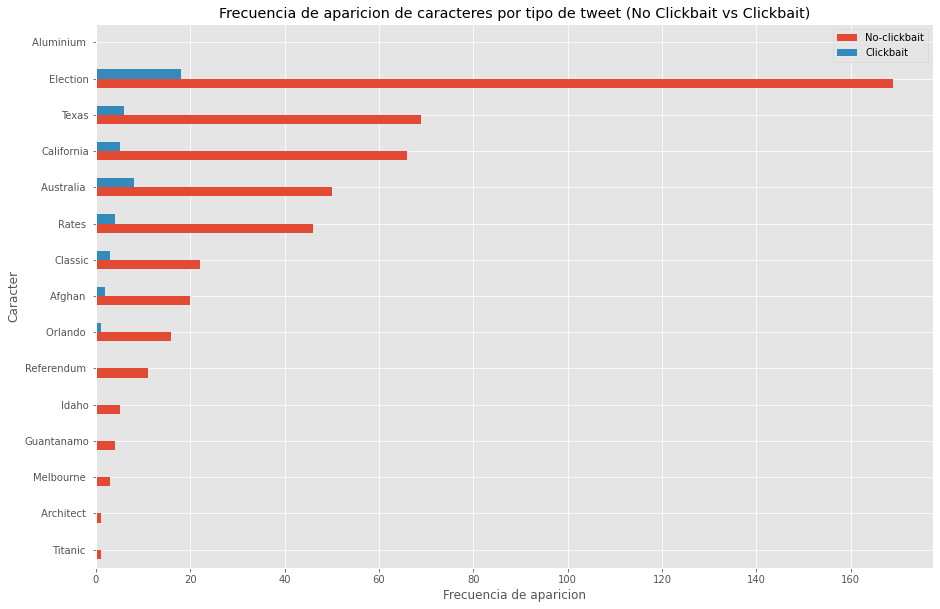

In [103]:
fig, ax = plt.subplots()
pd.DataFrame.from_dict(freq_words_dict, orient='index').sort_values(0).plot.barh(figsize=(15, 10),
                                                                  ax=ax)
plt.title("Frecuencia de aparicion de caracteres por tipo de tweet (No Clickbait vs Clickbait)")
ax.legend(["No-clickbait", "Clickbait"], loc='upper right');
plt.xlabel('Frecuencia de aparicion')
plt.ylabel('Caracter')
plt.show()

Comprobamos que prácticamente __la mayoría de los _tweets_ que contienen dichas palabras son principalmente _no clickbaits___. En ese sentido, existen indicios de "sesgo" en algunos de los caracteres anteriores: la mayoría pertenecen a _tweets_ que no son _clickbaits_, por lo que el modelo podría estar interpretando que estos términos, con los datos proporcionados, estén fuertemente asociados a _tweets_ que no son _clickbaits_.

Estos casos son un problema común en problemas de clasificación, donde algunos terminos (en función de los datos recolectados) suelen asociarse con una clase en particular. Para mayor detalle, recomiendo el siguiente _paper_:

[Reducing Unintended bias in Text
Classification using Multitask learning, by Veankata Sai Sukesh Settipalli
& Naga Manendra Kumar Dasireddy](https://www.diva-portal.org/smash/get/diva2:1534152/FULLTEXT02)

In [142]:
test_cleaned_df_filtered = test_cleaned_df[test_cleaned_df.postText_cleaned.str.contains('|'.join(list(freq_words_dict.keys())), regex=True)]
test_cleaned_df_filtered['less_than_0_5'] = test_cleaned_df_filtered[(test_cleaned_df_filtered.postText_cleaned.str.contains('|'.join(list(freq_words_dict.keys())),regex=True)) &\
                                                                     (test_cleaned_df_filtered.truthClass_numeric == 1)]['proba'].apply(lambda x: '< 0.5' if x < 0.5 else '>= 0.5')
test_cleaned_df_filtered.dropna(inplace=True)

De hecho, si analizamos __cuántos de los _tweets_ son clasificados correctamente, de tipo _clickbait_ y que contengan algunas de las palabras anteriores__:

In [141]:
test_cleaned_df_filtered['less_than_0_5'].value_counts()

< 0.5     16
>= 0.5     9
Name: less_than_0_5, dtype: int64

Comprobamos que tan solo es el 36 % de los casos (9 de los 25 totales). Nuevamente, mostramos algunos ejemplos:

In [ ]:
explainer   = shap.Explainer(f,tokenizer,output_names=["No-clickbait"])
shap_values = explainer(list(test_cleaned_df_filtered[test_cleaned_df_filtered['less_than_0_5'] == '< 0.5']\
                             .sort_values('proba').head(n=3)['postText_cleaned']))

In [148]:
for explainer_values in shap_values:
  shap.text_plot(explainer_values)

Como conclusión, de cara a un posterior análisis sería importante estudiar estos casos con mayor nivel de detalle, proponiendo diferentes soluciones:

1. En primer lugar, __probar a eliminar los signos de puntuación (tal y como se ha propuesto en el apartado de Falsos negativos) y comprobar si el número de falsos positivos se reduce__.

2. En primer lugar, __comparar los resultados de los _transformers_ por arquitecturas más simples como redes LSTM/biLSTM/GRU__, comprobando si dicho sesgo consigue mitigarse en estos modelos.

3. Por último, plantear la posibilidad de incluir nuevos _tweets_ con los que reducir dicho sesgo.

# Referencias

[Webis-clickbait dataset](https://webis.de/data/webis-clickbait-17.html)

[Hugging Face documentation](https://huggingface.co/docs)

[The Illustrated BERT - github.io](https://jalammar.github.io/illustrated-bert/)

[BERT, RoBERTa, DistillBERT, XLNet: which one to use? - Towards Data Science blog](https://towardsdatascience.com/bert-roberta-distilbert-xlnet-which-one-to-use-3d5ab82ba5f8)

[HuggingFace transformers fine-tuning DistillBERT for binary classification tasks - Towards Data Science blog](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)

[DistillBERT text classification using keras - Medium blog](https://swatimeena989.medium.com/distilbert-text-classification-using-keras-c1201d3a3d9d)

[HuggingFace DistillBERT Tensorflow for custom text classification - Medium blog](https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7)

[BERT in Keras & Tensorflow 2.0 using tfhub + HuggingFace - Medium blog](https://medium.com/analytics-vidhya/bert-in-keras-tensorflow-2-0-using-tfhub-huggingface-81c08c5f81d8)

[Text plot example using SHAP values](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/text.html)